# Principle Componenet Analysis: MNIST

Notebook / exercise from Philipp Eller.

**Useful functions**
- `np.eigh`

Today, we'll be back with MNIST (if you've started the homework, we've also been using it for homework 2).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
import scipy
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [5., 5.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

Let's explore the MNSIT dataset and use PCA to reduce its dimensionality.

In [3]:
def plot(X, y=None, rand=True):
    '''
    Plot 25 random examples from X
    '''
    fig, ax = plt.subplots(5,5)
    
    if rand:
        idx = np.random.choice(len(X), 25, replace=False)
    else:
        idx = np.arange(25)
    
    for i in range(25):
        axis = ax[i//5, i%5]
        axis.axis('off')
        s = int(np.sqrt(X.shape[-1]))
        axis.imshow(X[idx[i]].reshape(28,28), cmap='gray_r')
        if y is not None:
            axis.set_title('y = %s'%y[idx[i]])

**Open the dataset**

See instructions in the `data/README.md` file for how to download the data to use here :)

In [4]:
%%bash
ls ../data/MNIST_CSV/mnist_train.csv

../data/MNIST_CSV/mnist_train.csv


In [5]:
from numpy import genfromtxt
mnist_train = genfromtxt('../data/MNIST_CSV/mnist_train.csv', delimiter=',')

In [6]:
y = mnist_train[:,0]
X = mnist_train[:,1:]

print('X',X.shape)
print('y',y.shape)

X (60000, 784)
y (60000,)


What does the data look like?

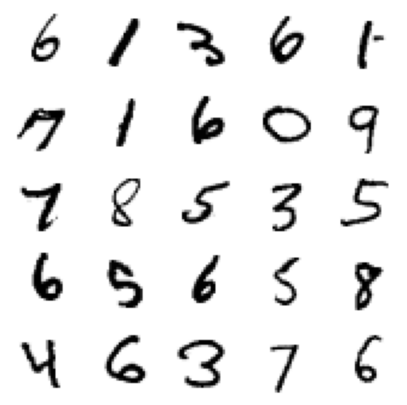

In [7]:
plot(X)

**Need to center the features before defining the sample covaraince matrix**

**Step 1:** Preprocessing
- "Flatten" X to have shape (N, 768)
- Subtract off the mean

In [8]:
N,d = X.shape

mean = np.average(X, axis=0)
X = X - mean

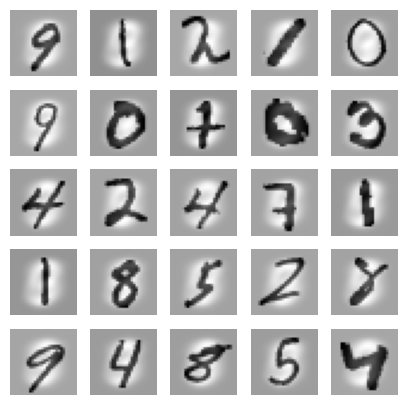

In [9]:
plot(X)

**Step 2:** Calculate the sample covariance matrix

In [10]:
'''
X has shape (N, 768), so taking the matmul of X.T and X gives the 
'''
covX = X.T @ X / (N-1)

**Step 3:** Do the eigenvalue decomposition

In [11]:
u, V = scipy.linalg.eigh(covX)

'''
Notational convenience: The `scipy.linalg.eigh` function
returns eigenvalues in _ascending order_ but the leading
values of u are the most important for PCA, so let's just 
reverse the order rn.
'''

u = u[::-1]
V = V[:,::-1]

In [12]:
# The columns of V are the eigenvectors
V.shape

(784, 784)

In [13]:
u.shape

(784,)

Sanity check: Can we reconstruct the sample covariance matrix from the eigenvectors?

Text(0.5, 1.0, 'Reco from eigenvectors')

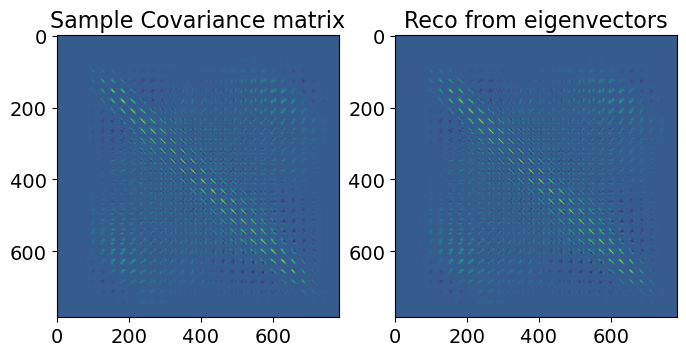

In [14]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))

ax0.imshow(covX)
ax0.set_title('Sample Covariance matrix')

ax1.imshow(V @ np.diag(u) @ V.T)
ax1.set_title('Reco from eigenvectors')

**Recall: What were we trying to maximimze?** -> The expected variance: 
$$Var(k) = \sum_k \frac{1}{N}||X v_k||_2^2,$$

or the L2 norm squared in the lower dimensional representation.

**Step 4:** Plot the expcted variance as a function of the dimensionality of the lower dim represnetation, $k$.

In [15]:
var_all = (1/N)*np.sum((X @ V)**2)
var_all

np.float64(3428445.4330706163)

In [16]:
var_kth_comp = (1/N) * np.array([ np.sum((X @ vk)**2) for vk in V.T ])

In [17]:
var_k = np.cumsum(var_kth_comp)

In [18]:
# Sanity check that these are the same
var_k[-1], var_all

(np.float64(3428445.433070625), np.float64(3428445.4330706163))

In [19]:
explained_variance_ratio = var_k / var_all

Text(0.5, 0, 'PCA component')

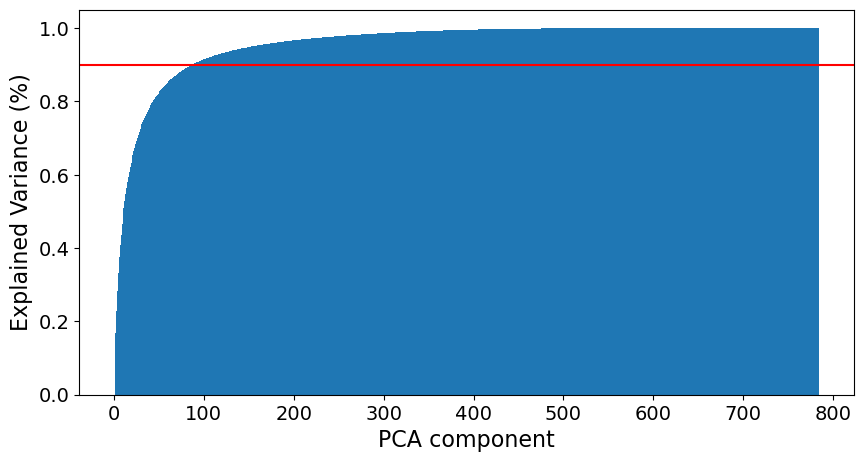

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(np.arange(d) + 1, explained_variance_ratio, width=1, label='cumulative')

xlim=plt.xlim()
plt.plot(xlim,[.9]*2,'r')
plt.xlim(xlim)

ax.set_ylabel('Explained Variance (%)')
ax.set_xlabel('PCA component')

**Follow up Q:** How many modes do you need to explain the expected variance?

By eye, it look like about 100.

In [22]:
for k in [10, 100,320]:
    print(k, explained_variance_ratio[k])

10 0.5092416997000108
100 0.915612589731981
320 0.9888798296634824


**Step 5:** How do the number of reco modes impact the reconstructed resolution (A.k.a, look at the plots for a low, med and high reconstruction value.)

k= 10


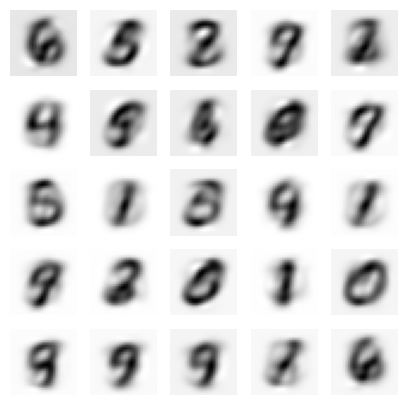

k= 100


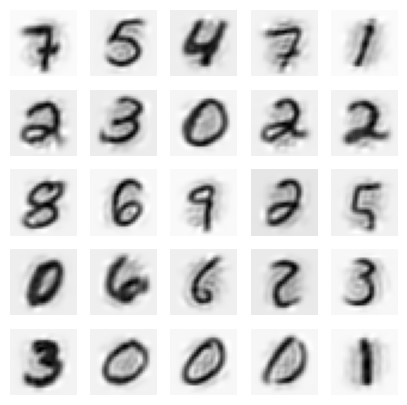

k= 320


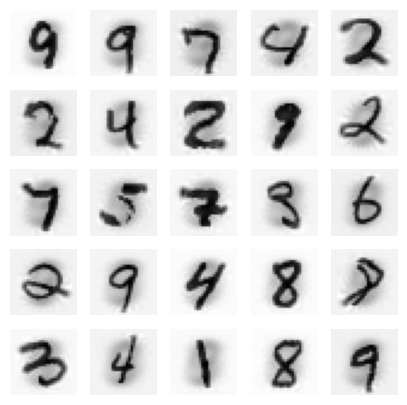

In [23]:
for k in [10, 100,320]:

    # for speed, I'm just going to look at 25 examples
    idx =  np.random.choice(N, 25, replace=False)
    
    # Project into the lower dim repn, then back into the higher dim one
    X_rec = X[idx] @ V[:,:k] @ V[:,:k].T

    # Add the mean back on
    X_rec += mean

    print('k=',k)
    plot(X_rec + mean,rand=False)
    plt.show()

**Step 6:** Visualize the 2d PCA space 

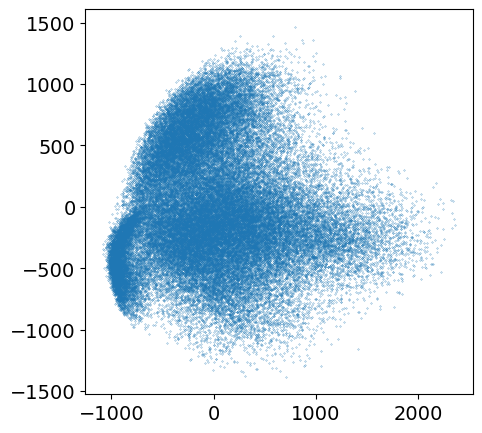

In [24]:
reduced_data = X @ V[:,:2]

_ = plt.scatter(reduced_data[:, 0], reduced_data[:, 1],s=.05)

Nice! Does this latent representation correspond to something meaningful for recognizing digits too?

**Step 7:** Color code the PCA vizualization based on the "truth" y values

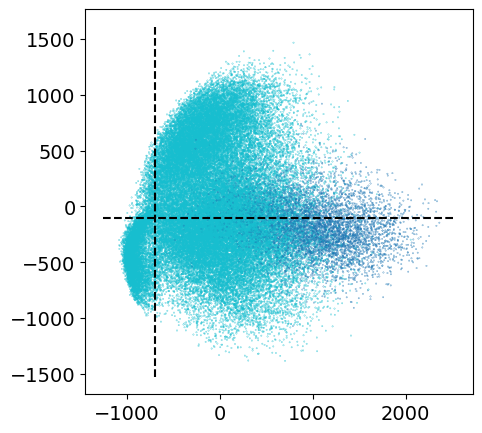

In [25]:
pca_2d = X @ V[:,:2] @ V[:,:2].T

plt.scatter(reduced_data[:, 0], reduced_data[:, 1],s=.05,c=plt.get_cmap('tab10')(y))

plt.vlines(-700,*plt.ylim(),color='k',ls='--')
plt.hlines(-100,*plt.xlim(),color='k',ls='--')

What are these "clusters" of points?

In [26]:
mask = (reduced_data[:, 0] < -700) & (reduced_data[:, 1] < -100)

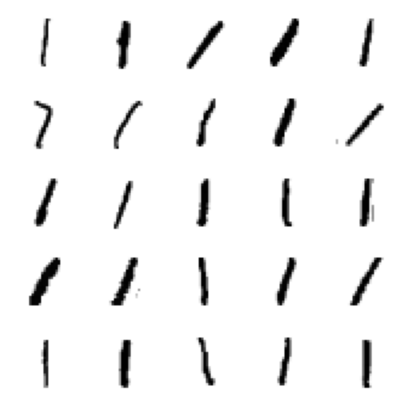

In [27]:
plot((X+mean)[mask])

Cool, the lower left corner mostly corresponding to 1s :)